### This notebook demonstrates the gaussian process regression training using lesional RNA eigengene modules for PASI prediction. The initial hyperparameters were chosen using a held-out 10 fold validation set in a previous script (not shown here). The validation patients were then removed to avoid overfitting. This script demonstrates the mean performance metrics for 20 testing/training splits using the chosen initial hyperparameter settings. Feature importance was generated towards the end of this notebook using the SHAP method.

In [ ]:
!pip install gpflow==2.5.2
!pip install shap==0.44.1
!pip install scikit-learn
!pip install tqdm

### **1. Import libraries**

In [16]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tqdm
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import gpflow
from gpflow import kernels
import tensorflow as tf
from sklearn.model_selection import KFold
import os

## **2. Load dataset and apply corrections and transformations**

In [6]:
df=pd.read_csv("AllRNAexp_PSORTvariables_one_hot_encoded_Features_with_missing_data_long_format_time_Series__skin_factors_skin_RNA_modules_NODUPLICATEFEATURES.csv")

# 111 training set size (80%) and (20%) 14 validation set (20%) 14 testing sets

# Remove validation patients that were used to find best hyperparameter combination (i.e. seed 42 split)
np.random.seed(42) # so have reproducible results when randomly split patient_IDs
IDs_patient=df['Patient_ID'].unique() # randomly sample
IDs_patient.shape # 139 patients. Use 0.1% of patients as test set, which is about 14 patients
Random_number_gen=np.random.randint(1,111,14) # choose 14 integers btw 1 and 111
validation_patients=list(IDs_patient[Random_number_gen]) #  subset the 14 patient IDs
df=df[-df['Patient_ID'].isin(validation_patients)].reset_index(drop=True) # remove validation patients


#### Need to correct some patients PASI scores based on group feedback

df.loc[(df['Patient_ID']=="P.6044") & (df['Time']==1),'Raw_PASI']=5.8
df.loc[(df['Patient_ID']=="P.60006") & (df['Time']==1),'Raw_PASI']=7

df=df.drop('Time',axis=1) # drop Time as we found time input causes severe overfitting

df=df.drop('Waist',axis=1) # Drop Waist as we assumed interchangeable with BMI.

df['Raw_PASI']=np.log(df['Raw_PASI']+1)

# **3. Run training/testing shuffles 20 times to get mean performance**
This section uses kernel hyperparameters chosen via a search space using a validation dataset in a previous script (unshown here). The validation patients were deleted from the training/testing shuffles in the previous section to avoid the risk of overfitting.

In [17]:

mean_absolute_error_=[]
r2_score_=[]

for j in tqdm(range(0,20),desc="Training on shuffled datasets"):

    from sklearn.preprocessing import RobustScaler

    # Only fit scalar to training dataset then use this fit to transform testing and validation splits this will avoid volatile metrics and data leakage.

    # 111 training set size (80%) and (10%) 14 validation set (10%) 14 testing sets
    #np.random.seed(42) # so have reproducible results when randomly split patient_IDs
    IDs_patient=df['Patient_ID'].unique() # randomly sample
    IDs_patient.shape # 139 patients. Use 0.1% of patients as test set, which is about 27 patients
    Random_number_gen=np.random.randint(1,111,14) # choose 14 integers btw 1 and 111
    test_patients=list(IDs_patient[Random_number_gen]) #  subset the 14 patient IDs
    test_df=df[df['Patient_ID'].isin(test_patients)] # subset these 14 patient IDs as test set
    train_df=df[-df['Patient_ID'].isin(test_patients)] # remove test patients from the original test df to get the final train df

    scaler = RobustScaler().fit(train_df.loc[:,'darkolivegreen':'lightgreen'].values) # fit to training dataset NOT VALIDATION SET
    X_trained_scaled = scaler.transform(train_df.loc[:,'darkolivegreen':'lightgreen'].values)
    X_test_scaled = scaler.transform(test_df.loc[:,'darkolivegreen':'lightgreen'].values)
    train_df.loc[:,'darkolivegreen':'lightgreen']=X_trained_scaled
    test_df.loc[:,'darkolivegreen':'lightgreen']=X_test_scaled

    X_tr = np.asarray(train_df.loc[:, 'darkolivegreen':'lightgreen'])  # Select X column inputs
    Y__tr = np.concatenate(np.asarray(train_df.loc[:, 'Raw_PASI']).reshape(len(X_tr), 1))  # Select Y column outputs

    X_ts = np.asarray(test_df.loc[:, 'darkolivegreen':'lightgreen'])  # Select X column inputs
    Y__ts = np.concatenate(np.asarray(test_df.loc[:, 'Raw_PASI']).reshape(len(X_ts), 1))  # Select Y column outputs


    models=[]
    kfold=[]
    mean_absolute_error_mean=[] ; mean_absolute_error_sd=[]
    r2_score_mean=[] ; r2_score_sd=[]
    mean_squared_error_mean=[]  ; mean_squared_error_sd=[]


    #print("Completing leave one out")
    X_train = tf.cast(X_tr, dtype=tf.float64)
    X_test = tf.cast(X_ts, dtype=tf.float64)
    Y_train = tf.cast(Y__tr.reshape(len(X_train),1), dtype=tf.float64)
    Y_test = tf.cast(Y__ts.reshape(len(X_test),1), dtype=tf.float64)

    zero_mean = gpflow.mean_functions.Zero() # specify a zero mean function

    k=gpflow.kernels.Matern52(lengthscales=3,variance=2) # the best hyperparameters based on search space
    for i in range(1,len(df.loc[:,"darkolivegreen":"lightgreen"].columns)):
        k_new=gpflow.kernels.Matern52(lengthscales=3,variance=2,active_dims=[i])
        k=k+k_new

    model_=gpflow.models.GPR((X_train,Y_train),kernel=k,mean_function=zero_mean) # use  GPR for regression task
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model_.training_loss,variables=model_.trainable_variables,options=dict(maxiter=100,disp=False))
    # MAXITER IS MORE IMPORTANT THAN WE THINK. Smaller dataset the lower maxiter. Can very easily overfit. Reccomend maxiter=100 for small/simple dataset and 1000 for complex dataset
    # from gpflow.utilities import print_summary
    # print_summary(model_)

    y_pred_test, v_test =model_.predict_y(X_test) # predict values for testing dataset
    f_pred_test, f_test =model_.predict_f(X_test) # predict values for testing dataset

    y_pred_train, v_train =model_.predict_y(X_train) # predict values for testing dataset
    f_pred_train, f_train =model_.predict_f(X_train) # predict values for testing dataset


    mae=mean_absolute_error(Y__ts,np.asarray(y_pred_test).reshape(len(X_ts),1))
    mean_absolute_error_.append(mae)

    r2=r2_score(Y__ts,np.asarray(y_pred_test).reshape(len(X_ts),1))
    r2_score_.append(r2)
    #print(r2_score_)

mean_absolute_error_=np.asarray(mean_absolute_error_)
r2_score_=np.asarray(r2_score_)

Test_shuffle_results_RNA_only=pd.DataFrame({'mae_mean':[np.mean(mean_absolute_error_)],'mae_std':[np.std(mean_absolute_error_)],'r2_mean':[np.mean(r2_score_)],'r2_std':[np.std(r2_score_)]},
                                columns=["mae_mean","mae_std","r2_mean","r2_std"]) # write results to file


Test_shuffle_results_RNA_only # final mean results


Training on shuffled datasets: 100%|██████████| 20/20 [11:13<00:00, 33.67s/it]


,mae_mean,mae_std,r2_mean,r2_std
0,0.4717,0.066998,0.512952,0.095175


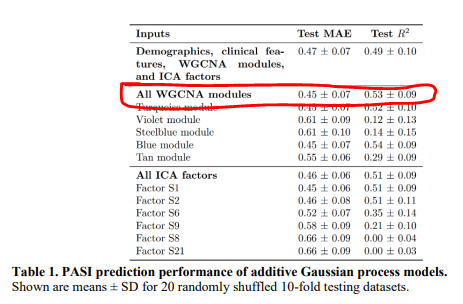

## **4. Determine feature importance using shap method**

PermutationExplainer explainer: 328it [1:34:06, 17.27s/it]


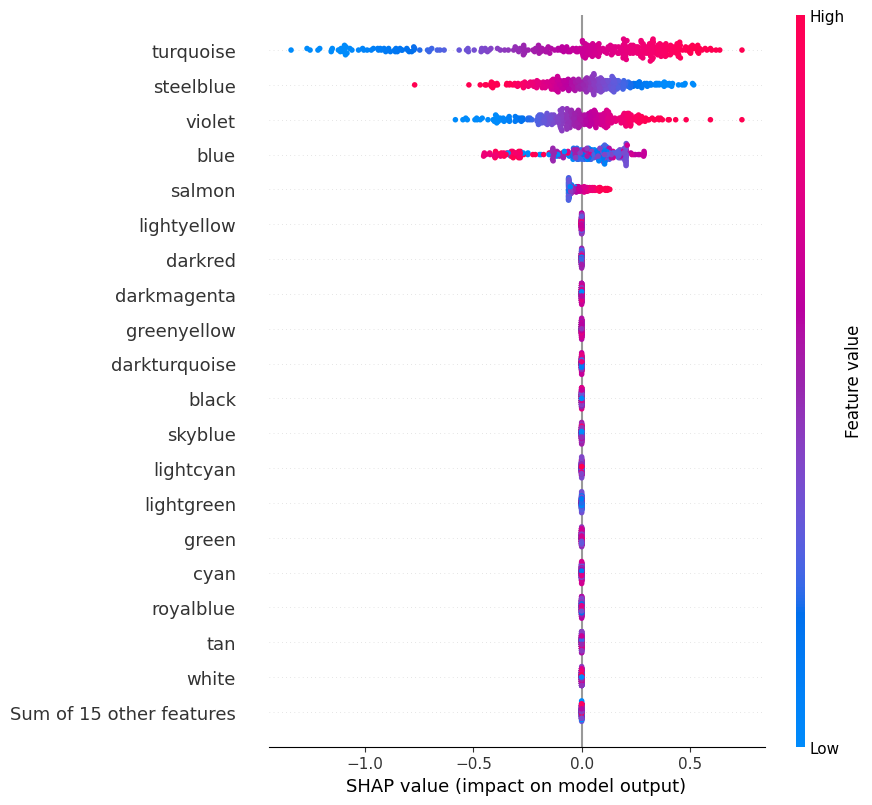

In [18]:

import matplotlib.pyplot as plt
import shap

X_train=np.asarray(X_train)
X_train.shape

def predict_fn(X):
    mean, _ = model_.predict_y(X) # need to place GP model in a wrapper function as shap does not need the predicted variance. SHAP only requires predicted mean.
    return mean.numpy()  # Assuming mean is a TensorFlow tensor, convert to numpy array

# Feature importance using SHAP method
explainer_ridge = shap.Explainer(predict_fn,X_train)
shap_values_ridge = explainer_ridge.shap_values(X_train)

explanation_ridge = shap.Explanation(values=shap_values_ridge,
                                     data=X_train,
                                     feature_names=train_df.loc[:, 'darkolivegreen':'lightgreen'].columns)


# Visualize SHAP summary plots or waterfall plots to understand feature importance
shap.plots.beeswarm(explanation_ridge, max_display=20) # do max 20 features
